# Epsilon greedy algorithm

In [1]:
import numpy as np
import copy

np.set_printoptions(precision=3)

class Environment:
    def __init__(self, thetas: [float]):
        self.thetas = thetas


class State:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

class EpsilonGreedy:
    @classmethod
    def get_arm(cls, state: State, eps: float=0.1) -> int:
        # Decide to either explore or exploit
        if np.random.random() < eps:
            arm = np.random.randint(state.n_arms)
        else:
            arm = np.argmax(state.values)
        return arm


def react(env: Environment, arm: int) -> float:
    if np.random.random() < env.thetas[arm]:
        return 1.0
    else:
        return 0


def update(state: State, arm: int, reward: float) -> State:
    s = copy.deepcopy(state)
    s.counts[arm] += 1
    s.values[arm] = ((s.counts[arm] - 1) * s.values[arm] + reward) / s.counts[arm]
    return s

In [2]:
thetas = [0.05, 0.08]

env = Environment(thetas)
state = State(len(thetas))
states = [state]
rewards = []

num_trials = 1000

for i in range(num_trials):
    arm = EpsilonGreedy.get_arm(state)

    reward = react(env, arm)
    rewards.append(reward)

    state = update(state, arm, reward)
    states.append(state)

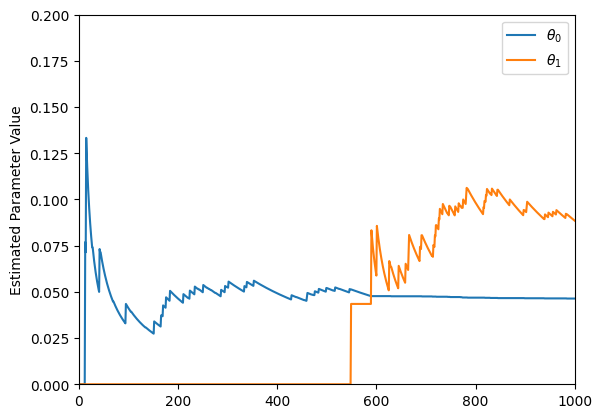

In [3]:
import matplotlib.pyplot as plt

theta_evolution = np.array([s.values for s in states])
plt.plot(theta_evolution[:,0], label=r"$\theta_0$")
plt.plot(theta_evolution[:,1], label=r"$\theta_1$")
plt.legend()

plt.ylabel("Estimated Parameter Value")

plt.xlim([0, 1000])
plt.ylim([0, 0.2])
plt.show()

In [4]:
class Oracle:
    @classmethod
    def get_arm(cls, env: Environment) -> int:
        return np.argmax(env.thetas)

opt_rewards = []
for i in range(num_trials):
    arm = Oracle.get_arm(env)

    reward = react(env, arm)
    opt_rewards.append(reward)

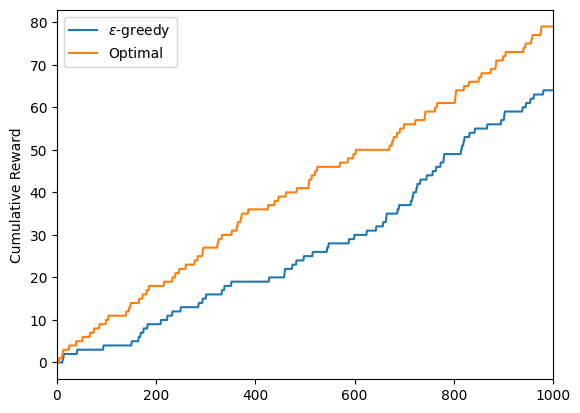

In [5]:
plt.plot(np.cumsum(rewards), label=r"$\epsilon$-greedy")
plt.plot(np.cumsum(opt_rewards), label=r"Optimal")
plt.legend()
plt.ylabel("Cumulative Reward")
plt.xlim([0, 1000])

plt.show()

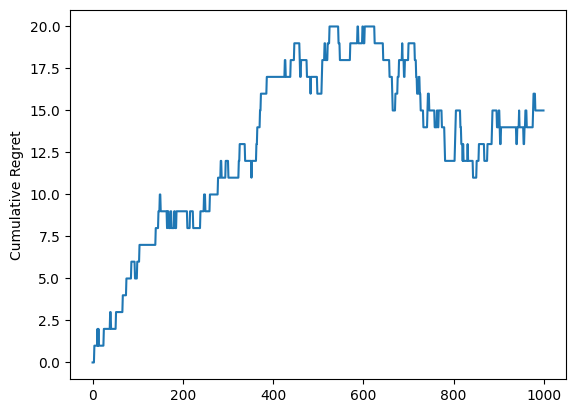

In [6]:
import matplotlib.pyplot as plt

regrets = np.cumsum(opt_rewards) - np.cumsum(rewards)
plt.plot(regrets)
plt.ylabel("Cumulative Regret")
plt.show()

# Softmax bandit

In [7]:
class Softmax:
    @classmethod
    def get_arm(cls, state: State, tau: float=0.05) -> int:
        logit = state.values / tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        arm = np.random.choice(state.n_arms, p=p)
        return arm

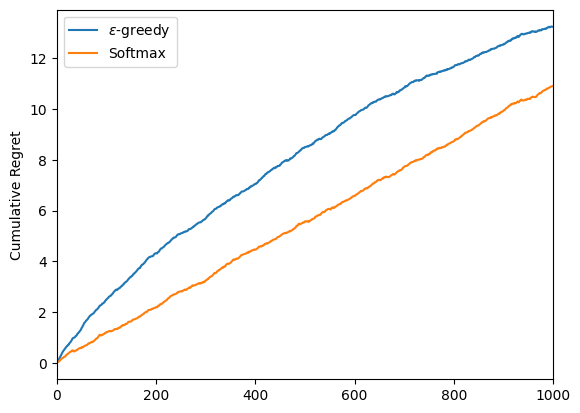

In [8]:
import matplotlib.pyplot as plt

thetas = [0.05, 0.08]

env = Environment(thetas)

def simulate(num_simulation=1000):
    eg_regrets = []
    sm_regrets = []

    for i in range(num_simulation):
        num_trials = 1000

        # Oracle
        opt_rewards = []
        for i in range(num_trials):
            arm = Oracle.get_arm(env)

            reward = react(env, arm)
            opt_rewards.append(reward)

        # Eps-greedy
        eg_state = State(len(thetas))
        eg_rewards = []
        for i in range(num_trials):
            arm = EpsilonGreedy.get_arm(eg_state)
            reward = react(env, arm)
            eg_rewards.append(reward)
            eg_state = update(eg_state, arm, reward)

        # Softmax
        sm_state = State(len(thetas))
        sm_rewards = []
        for i in range(num_trials):
            arm = Softmax.get_arm(sm_state)

            reward = react(env, arm)
            sm_rewards.append(reward)

            sm_state = update(sm_state, arm, reward)

        # Calculate regrets
        _eg_regrets = np.cumsum(opt_rewards) - np.cumsum(eg_rewards)
        eg_regrets.append(_eg_regrets)

        _sm_regrets = np.cumsum(opt_rewards) - np.cumsum(sm_rewards)
        sm_regrets.append(_sm_regrets)

    eg_regrets = np.array(eg_regrets)
    sm_regrets = np.array(sm_regrets)
    eg_mean_regrets = np.mean(eg_regrets, axis=0)
    sm_mean_regrets = np.mean(sm_regrets, axis=0)


    plt.plot(eg_mean_regrets, label=r"$\epsilon$-greedy")
    plt.plot(sm_mean_regrets, label="Softmax")
    plt.legend()

    plt.ylabel("Cumulative Regret")
    plt.xlim([0, 1000])
    plt.show()

simulate()

# Thompson Sampling

In [12]:
class TSState:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

class ThompsonSampling:
    @classmethod
    def get_arm(cls, state: TSState) -> int:
        beta = lambda N, a: np.random.beta(a + 1, N - a + 1)
        dist = [beta(state.counts[i], state.values[i]) for i in range(state.n_arms)]
        arm = dist.index(max(dist))
        return arm

def react(env: Environment, arm: int) -> float:
    if np.random.random() < env.thetas[arm]:
        return 1.0
    else:
        return 0

def ts_update(state: TSState, arm: int, reward: float) -> State:
    s = copy.deepcopy(state)
    s.counts[arm] += 1
    s.values[arm] += reward
    return s

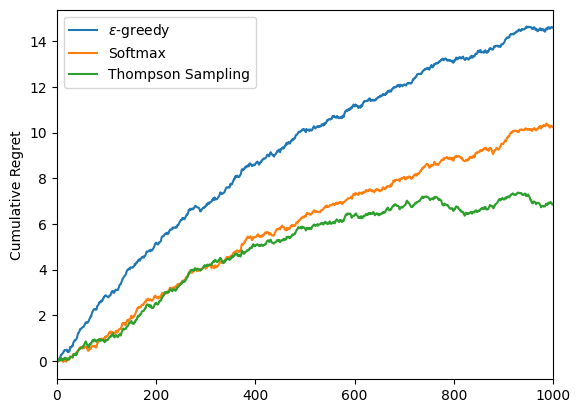

In [13]:
import matplotlib.pyplot as plt

thetas = [0.05, 0.08]

env = Environment(thetas)

def simulate(num_simulation=100):
    eg_regrets = []
    sm_regrets = []
    ts_regrets = []

    for i in range(num_simulation):
        num_trials = 1000

        # Oracle
        opt_rewards = []
        for i in range(num_trials):
            arm = Oracle.get_arm(env)

            reward = react(env, arm)
            opt_rewards.append(reward)

        # Eps-greedy
        eg_state = State(len(thetas))
        eg_rewards = []
        for i in range(num_trials):
            arm = EpsilonGreedy.get_arm(eg_state)
            reward = react(env, arm)
            eg_rewards.append(reward)
            eg_state = update(eg_state, arm, reward)

        # Softmax
        sm_state = State(len(thetas))
        sm_rewards = []
        for i in range(num_trials):
            arm = Softmax.get_arm(sm_state)

            reward = react(env, arm)
            sm_rewards.append(reward)

            sm_state = update(sm_state, arm, reward)

        # ThompsonSampling
        ts_state = TSState(len(thetas))
        ts_rewards = []
        for i in range(num_trials):
            arm = ThompsonSampling.get_arm(ts_state)
            reward = react(env, arm)
            ts_rewards.append(reward)
            ts_state = ts_update(ts_state, arm, reward)

        # Calculate regrets
        _eg_regrets = np.cumsum(opt_rewards) - np.cumsum(eg_rewards)
        eg_regrets.append(_eg_regrets)

        _sm_regrets = np.cumsum(opt_rewards) - np.cumsum(sm_rewards)
        sm_regrets.append(_sm_regrets)

        _ts_regrets = np.cumsum(opt_rewards) - np.cumsum(ts_rewards)
        ts_regrets.append(_ts_regrets)

    eg_regrets = np.array(eg_regrets)
    sm_regrets = np.array(sm_regrets)
    ts_regrets = np.array(ts_regrets)
    eg_mean_regrets = np.mean(eg_regrets, axis=0)
    sm_mean_regrets = np.mean(sm_regrets, axis=0)
    ts_mean_regrets = np.mean(ts_regrets, axis=0)

    plt.plot(eg_mean_regrets, label=r"$\epsilon$-greedy")
    plt.plot(sm_mean_regrets, label="Softmax")
    plt.plot(ts_mean_regrets, label="Thompson Sampling")
    plt.legend()

    plt.ylabel("Cumulative Regret")
    plt.xlim([0, 1000])
    plt.show()

simulate()